In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
from pathlib import Path

In [3]:
home = Path('/content/drive/My Drive/Carl_time_series_classification_project/Data_files/Data_file')
data_dir = Path('/content/drive/My Drive/Carl_time_series_classification_project/Data_files/Data_file/Data')

##  S&P500 Prediction using Machine Learning

***
*Created by - Vaibhav Singh Tomar & Carl Barrelet*

*Code compression being done by - Shadab Sayeed and Vaibhav*
***

**Predicting Daily S&P500 (Up and Down) using XGBoost Algorithm with Sharpe Ratio as the key performance metric. The Sharpe ratio was developed by Nobel laureate William F. Sharpe and is used to help investors understand the return of an investment compared to its risk. The ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk. Volatility is a measure of the price fluctuations of an asset or portfolio.**

*Historical Data extracted from EIKON API from Jan 2010 to Dec 2019. List of tickers available in ReadMe.xlsx*


**The model employs XGBoost Binary Classifier to train on 8 years worth of Historical Data both In-Sample & Out-of-Sample and predict two classes (O and 1) for the Daily SP500 Returns**

In [ ]:
# Importing the Libraries
!pip install bt==0.2.7
!pip install tscv==0.0.4
!pip install shap==0.35.0
!pip install lime==0.2.0.1
!pip uninstall xgboost -y
!pip install xgboost==1.2.0
!pip install -q catboost
!pip install -q lightgbm
import bt
import csv
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
import xgboost as xgb
from datetime import datetime
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc, roc_auc_score
from tscv import gap_train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from tscv import GapWalkForward
from sklearn.model_selection import TimeSeriesSplit as TimeBasedCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
import time
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from statistics import mean
import statsmodels.api as sm
from statsmodels import regression
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import lime
import lightgbm
import matplotlib
from matplotlib import pyplot as plt
from numpy import loadtxt
import shap
import types
from sklearn.decomposition import PCA
import pkg_resources
import types

In [5]:
%matplotlib inline

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
import joblib
import re

In [33]:
df2 = pd.read_csv('/content/refinitivData_20201110.csv')
df2.drop(df2.head(2).index, inplace = True )
rename_dict = {'Instrument':'Date',".SPX":"Index_High",".SPX.1":"Index_Close",".SPX.2":"Index_Low",".SPX.3":"Index_Open",
               "ISPCS00":"ISPC_High","ISPCS00.1":"ISPC_Low","ISPCS00.2":"ISPC_Open","ISPCS00.3":"ISPC_Close"}
df2.rename(columns=rename_dict,inplace=True)
df2.reset_index(drop=True,inplace=True)

* **BRKb.N, C.N, CHD.N, BIIB.OQ**

## Preprocessing

In [34]:
# Evaluating the Volatility

def vol_generation(pd_input):
    Volatility3 = (pd_input.rolling(window=3).std() * np.sqrt(252 / 3)) / 10
    Volatility5 = (pd_input.rolling(window=5).std() * np.sqrt(252 / 5)) / 10
    Volatility22 = (pd_input.rolling(window=22).std() * np.sqrt(252 / 22)) / 10
    Volatility3 = Volatility3.astype(float)
    Volatility5 = Volatility5.astype(float)
    Volatility22 = Volatility22.astype(float)
    Vol_Ratio = Volatility5/Volatility22
    
    return Volatility3, Volatility5, Volatility22, Vol_Ratio   

In [35]:
def return_diff(X,cols):
    df1 = X.copy()
    for c in cols:
        df1[c] = pd.to_numeric(df1[c],errors='coerce')
    for c in cols:
        name = str(c)+"_RD"
        df1[name] = df1[c] - df1['Index_Close']
    return df1

In [39]:
def data_preprocess(X):
    df = X.copy()
    df['Date'] = pd.to_datetime(df['Date'],errors='coerce')
    df['day_of_week'] = df['Date'].dt.day_name()
    # Here we are generating dy of week because some days more important to trade or not to trade, So we are keeping a generalised feature.
    df['day_of_week'].replace({'Monday':0,'Tuesday':1,'Wednesday':3,'Thursday':3,'Friday':4},inplace=True)
    data_10_19 = df.copy()

    #We are selecting only those rows where Index High is not NaN because that will be trading days
    data_10_19 = data_10_19[data_10_19["Index_High"].notna()].copy()
    data_10_19.set_index("Date",inplace=True)

    # These are the ticker we select using Time Series Walk forward C.V over a period of 3 year. We selected features with
    # highest shapley values each month, aggregated them and then took a set of top 30 features.
    df_cols = ['AIV.N', 'AMZN.OQ', 'APD.N', 'BBY.N', 'BIIB.OQ', 'BRKb.N', 'C.N','CAT.N', 'CBOE.Z', 
           'CHD.N', 'CINF.OQ', 'DIS.N', 'DLTR.OQ', 'EFX.N','EVRG.N', 'FMC.N', 'HSIC.OQ','HGc1' ,
           'IVZ.N', 'KMI.N', 'LLY.N', 'MMM.N', 'MOS.N', 'MRK.N', 'PEAK.N', 'PEP.OQ', 'RHI.N', 'SRE.N', 
           'SYK.N','TRV.N', 'UNH.N', 'UPS.N','Index_Close','day_of_week']

    #Sanity check converting values to numeric in case some thing is left
    for cl in df_cols:data_10_19[cl] = pd.to_numeric(data_10_19[cl],errors='coerce')

    data = data_10_19[df_cols].copy()

    #Sanity check converting values to numeric in case some thing is left
    for c in df_cols:data[c] = pd.to_numeric(data[c],errors='coerce')
    
    tar_col = "Index_Close"

    # Evaluating the 3,5 and 22 day SP500 Returns
    Returns3 = data[tar_col].pct_change(periods=3)
    Returns5 = data[tar_col].pct_change(periods=5)
    Returns22 = data[tar_col].pct_change(periods=22)

    #these are the columns that we will calculate pct_change from previous day
    pct_cols = ['AIV.N', 'AMZN.OQ', 'APD.N', 'BBY.N', 'BIIB.OQ', 'BRKb.N', 'C.N','CAT.N', 'CBOE.Z', 
           'CHD.N', 'CINF.OQ', 'DIS.N', 'DLTR.OQ', 'EFX.N','EVRG.N', 'FMC.N', 'HSIC.OQ','HGc1' ,
           'IVZ.N', 'KMI.N', 'LLY.N', 'MMM.N', 'MOS.N', 'MRK.N', 'PEAK.N', 'PEP.OQ', 'RHI.N', 'SRE.N', 
           'SYK.N','TRV.N', 'UNH.N', 'UPS.N','Index_Close']

    # Pre-Processing Data
    data[pct_cols] = data[pct_cols].pct_change()

    #Adding trending variable
    # To see if market if is in upward/downward trend from previous days
    tr_col = data['Index_Close'].values
    trends = [0,0]
    prev_val = tr_col[1]
    for idx in range(2,len(tr_col)):
        if tr_col[idx]>0 and prev_val>0:
            trends.append(trends[idx-1]+1)
        elif tr_col[idx]<0 and prev_val<0:
            trends.append(trends[idx-1]-1)
        else:
            trends.append(0) 
    
    #Calculating return differential as Explained Above
    rd_cols =  ['AIV.N', 'AMZN.OQ', 'APD.N', 'BBY.N', 'BIIB.OQ', 'BRKb.N', 'C.N','CAT.N', 'CBOE.Z', 
           'CHD.N', 'CINF.OQ', 'DIS.N', 'DLTR.OQ', 'EFX.N','EVRG.N', 'FMC.N', 'HSIC.OQ','HGc1' ,
           'IVZ.N', 'KMI.N', 'LLY.N', 'MMM.N', 'MOS.N', 'MRK.N', 'PEAK.N', 'PEP.OQ', 'RHI.N', 'SRE.N', 
           'SYK.N','TRV.N', 'UNH.N', 'UPS.N']

    # Adding return differential
    data = return_diff(data,rd_cols)
    a = pd.DataFrame()
    a["log_ret"] = data["Index_Close"].pct_change()

    #Adding volatility for explanation see above
    data["Volatility3"], data["Volatility5"], data["Volatility22"], data["Vol_Ratio"] = vol_generation(a["log_ret"])

    #Adding consecutive trend and commulative trend
    # How many consecutive days index is up or down
    data['symbol'] = data['Index_Close'].apply(lambda x : 1 if x>0 else -1)
    sym = data['symbol'].values

    #Consective trending days
    consctv = [0,0]
    for i in range(2,len(sym)):
        ans = sym[i] if sym[i-1]==sym[i] else 0
        consctv.append(ans)
    data['consecutive'] = consctv

    #Commulative trending days
    comm_cons = [0,0,0]
    for j in range(3,len(consctv)):
        if consctv[j]>0 or consctv[j]<0:
            cs = 0
            for s in range(j,2,-1):
                if consctv[s]!=0:
                    cs+=consctv[s]
                else:
                    break
        comm_cons.append(cs)
        cs = 0

    data['comm_cons'] = comm_cons

    #Shifting target 1 up because we are predicting net day behavior
    data = data.fillna(axis=1, method="ffill")
    data[tar_col] = data[tar_col].shift(-1)

    #Adding target and big moves
    data["Target"] = np.array([1 if x>0 else 0 for x in data[tar_col]])

    # I am still trying to understand this clearly...............
    data["big_moves"] = pd.DataFrame(data[tar_col].apply(lambda x: abs(x)) > 0.8 * data[tar_col].std()).astype(int)
    data["big_moves_pos"] = pd.DataFrame(data[tar_col] > 0.8 * data[tar_col].std()).astype(int)
    data["big_moves_neg"] = pd.DataFrame(data[tar_col] < - 0.8 * data[tar_col].std()).astype(int)

    #adding returns  to data
    data["Returns3"] = Returns3 # 3 days returns
    data["Returns5"] = Returns5 # 5 days returns
    data["Returns22"] = Returns22 # 22 days returns

    #Adding volatility ratio trend
    #it kind of pseudo feature to detect some big events happening in the market
    #Vol_ratio will be positive is there have a signifcant high volatility in previous week in the market
    data["Vol_Ratio_Trend"] = data["Vol_Ratio"] * data["Returns3"].apply(lambda x: np.sign(x))

    #Adding volatility to dataframe
    data["Volatility3"] = data["Volatility3"].astype(float)
    data["Volatility5"] = data["Volatility5"].astype(float)
    data["Volatility22"] = data["Volatility22"].astype(float)
    data["Vol_Ratio"] = data["Vol_Ratio"].astype(float)
    data["Vol_Ratio_Trend"] = data["Vol_Ratio_Trend"].astype(float)

    # Set Binary Parameters for the Target Variable
    data.drop(data.tail(1).index, inplace=True) # Becasue we are shifting SPX by one up
    data.drop(data.head(3).index, inplace=True) # because we are calculating 3 days returns of SPX 
    data = data.fillna(axis=1, method="ffill")

    #Adding if day is Friday
    ''' 
    If Monday may be the best day of the week to buy stocks, Friday may be the best day to sell stock — before prices dip on Monday. 
    If you're interested in short selling, then Friday may be the best day to take a short position (if stocks are priced higher on Friday),
    and Monday would be the best day to cover your short.
    '''
    data["Friday"] = data["day_of_week"] == 4
    data["Friday"] = data["Friday"].astype(int)
    #finding start date
    start = data.index.searchsorted(datetime(2010, 1, 8))
    data = data.iloc[start:].copy()
    data_chk = data.copy() #creating a copy for saving

    #Finals cols to be used in model training 
    fin_cols = ['AIV.N', 'AMZN.OQ', 'APD.N', 'BBY.N', 'BIIB.OQ', 'BRKb.N', 'C.N',
                'CAT.N', 'CBOE.Z', 'CHD.N', 'CINF.OQ', 'DIS.N', 'DLTR.OQ', 'EFX.N',
                'EVRG.N', 'FMC.N', 'HSIC.OQ', 'HGc1', 'IVZ.N', 'KMI.N', 'LLY.N',
                'MMM.N', 'MOS.N', 'MRK.N', 'PEAK.N', 'PEP.OQ', 'RHI.N', 'SRE.N',
                'SYK.N', 'TRV.N', 'UNH.N', 'UPS.N', 'Index_Close', 'day_of_week', 'AIV.N_RD', 'AMZN.OQ_RD', 'APD.N_RD', 'BBY.N_RD',
                'BIIB.OQ_RD', 'BRKb.N_RD', 'C.N_RD', 'CAT.N_RD', 'CBOE.Z_RD',
                'CHD.N_RD', 'CINF.OQ_RD', 'DIS.N_RD', 'DLTR.OQ_RD', 'EFX.N_RD',
                'EVRG.N_RD', 'FMC.N_RD', 'HSIC.OQ_RD', 'HGc1_RD', 'IVZ.N_RD',
                'KMI.N_RD', 'LLY.N_RD', 'MMM.N_RD', 'MOS.N_RD', 'MRK.N_RD', 'PEAK.N_RD',
                'PEP.OQ_RD', 'RHI.N_RD', 'SRE.N_RD', 'SYK.N_RD', 'TRV.N_RD', 'UNH.N_RD',
                'UPS.N_RD','Returns3', 'Returns5', 'Returns22','Target','symbol', 'consecutive','comm_cons', "Volatility3",
                "Volatility5","Volatility22","Vol_Ratio", "Friday", "Vol_Ratio_Trend"]

    #Converting features to numeric values   
    for c in fin_cols:data[c] = pd.to_numeric(data[c],errors='coerce')

    #Spliting the dataset in features and Targets
    X = data.copy()
    y = data["Target"].copy()

    X.drop(["Target"], inplace=True, axis=1)
    X.drop([tar_col], inplace=True, axis=1)

    return X, y,data

In [40]:
X,y,data = data_preprocess(df2)

In [41]:
data

,AIV.N,AMZN.OQ,APD.N,BBY.N,BIIB.OQ,BRKb.N,C.N,CAT.N,CBOE.Z,CHD.N,CINF.OQ,DIS.N,DLTR.OQ,EFX.N,EVRG.N,FMC.N,HSIC.OQ,HGc1,IVZ.N,KMI.N,LLY.N,MMM.N,MOS.N,MRK.N,PEAK.N,PEP.OQ,RHI.N,SRE.N,SYK.N,TRV.N,UNH.N,UPS.N,Index_Close,day_of_week,AIV.N_RD,AMZN.OQ_RD,APD.N_RD,BBY.N_RD,BIIB.OQ_RD,BRKb.N_RD,...,CBOE.Z_RD,CHD.N_RD,CINF.OQ_RD,DIS.N_RD,DLTR.OQ_RD,EFX.N_RD,EVRG.N_RD,FMC.N_RD,HSIC.OQ_RD,HGc1_RD,IVZ.N_RD,KMI.N_RD,LLY.N_RD,MMM.N_RD,MOS.N_RD,MRK.N_RD,PEAK.N_RD,PEP.OQ_RD,RHI.N_RD,SRE.N_RD,SYK.N_RD,TRV.N_RD,UNH.N_RD,UPS.N_RD,Volatility3,Volatility5,Volatility22,Vol_Ratio,symbol,consecutive,comm_cons,Target,big_moves,big_moves_pos,big_moves_neg,Returns3,Returns5,Returns22,Vol_Ratio_Trend,Friday
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-08,-0.023177,0.027077,0.006395,-0.039239,0.020568,-0.000286,-0.016438,0.011228,0.011228,-0.002162,-0.003375,0.001571,-0.013795,0.000313,0.008825,-0.008852,0.005964,-0.004676,-0.005640,-0.005640,-0.007655,0.007046,0.014294,-0.000530,0.006619,-0.003280,-0.000684,-0.000557,0.003077,-0.001439,-0.009391,0.048075,0.001747,4.0,-0.026059,0.024195,0.003514,-0.042121,0.017686,-0.003168,...,0.008347,-0.005044,-0.006256,-0.001311,-0.016676,-0.002569,0.005943,-0.011734,0.003083,-0.007558,-0.008522,-0.008522,-0.010537,0.004165,0.011413,-0.003412,0.003737,-0.006162,-0.003566,-0.003439,0.000195,-0.004321,-0.012273,0.045194,3.652843,3.652843,3.652843,3.652843,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.007444,0.007444,0.007444,3.652843,1
2010-01-11,0.007717,-0.024056,0.018328,-0.017038,-0.003326,0.000900,0.011142,0.062811,0.062811,-0.004334,0.007524,-0.016311,-0.005473,-0.009393,0.015193,-0.027338,0.032988,0.008662,0.030977,0.030977,0.013714,-0.004032,-0.005847,0.003979,0.011176,-0.001152,0.004793,0.014495,-0.003067,-0.000412,0.006728,0.044042,-0.009381,0.0,0.005970,-0.025803,0.016581,-0.018785,-0.005073,-0.000847,...,0.061064,-0.006081,0.005778,-0.018058,-0.007220,-0.011139,0.013447,-0.029085,0.031242,0.006916,0.029231,0.029231,0.011968,-0.005779,-0.007594,0.002232,0.009429,-0.002899,0.003046,0.012749,-0.004814,-0.002159,0.004981,0.042295,3.530630,3.530630,3.530630,3.530630,1.0,1.0,3.0,0.0,1.0,0.0,1.0,0.008653,0.012348,0.012348,3.530630,0
2010-01-12,-0.025898,-0.022700,-0.012719,0.000765,-0.012061,-0.007486,-0.030303,-0.029471,-0.029471,0.025448,-0.001867,-0.017219,0.011826,-0.006005,-0.004989,-0.003489,-0.013997,-0.036390,-0.014388,-0.014388,-0.003382,0.000834,-0.057608,-0.007926,-0.016905,0.014003,-0.035434,-0.003480,-0.000724,0.006386,-0.026428,-0.006686,0.008326,1.0,-0.016517,-0.013319,-0.003338,0.010146,-0.002680,0.001895,...,-0.020090,0.034829,0.007514,-0.007838,0.021208,0.003376,0.004392,0.005892,-0.004616,-0.027009,-0.005007,-0.005007,0.005999,0.010215,-0.048227,0.001455,-0.007524,0.023384,-0.026053,0.005901,0.008657,0.015768,-0.017047,0.002695,3.193212,3.197763,3.197763,3.197763,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.004791,-0.000264,-0.000264,-3.197763,0
2010-01-13,0.027790,0.013820,0.009966,0.011971,0.015587,-0.000030,-0.005682,0.001446,0.001446,0.013061,0.008979,0.015250,-0.004835,0.010175,0.009572,0.003871,0.026386,0.017069,0.003864,0.003864,0.013857,-0.003212,0.000800,0.036751,0.007606,0.008123,0.003886,-0.009743,0.004709,0.003480,0.015289,-0.005288,0.002427,3.0,0.019465,0.005494,0.001640,0.003646,0.007261,-0.008356,...,-0.006880,0.004735,0.000653,0.006924,-0.013161,0.001849,0.001246,-0.004455,0.018060,0.008744,-0.004462,-0.004462,0.005532,-0.011538,-0.007526,0.028425,-0.000719,-0.000202,-0.004440,-0.018068,-0.003617,-0.004846,0.006963,-0.013614,2.850818,3.237007,3.237007,3.237007,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000611,0.007510,0.007510,3.237007,0
2010-01-14,-0.011170,-0.013632,-0.012394,-0.009565,0.005179,-0.000606,0.002857,-0.005615,-0.005615,0.007736,0.002225,-0.008629,-0.003036,0.006610,0.001354,-0.014875,-0.004790,0.007872,-0.016253,-0.016253,0.004184,-0.003342,-0.027183,0.027228,-0.002953,0.012087,0.014075,-0.005012,0.009915,0.005304,0.023970,0.002094,-0.010823,3.0,-0.013596,-0

In [43]:
start = data.index.searchsorted(datetime(2010, 1, 8))
end = data.index.searchsorted(datetime(2019, 12, 30))
start,end

(0, 2510)

In [44]:
data = data.iloc[start:end+1]

**Walk Forward Cross Validation**

To avoid luck as a factor and have a more robust result that we can trust,
we can expand on the concept of Train-Test Split by doing what is known as walk-forward validation.
![Walk Forward Cross Validation](https://conlanscientific.com/media/content/walk-forward-optimization.png)

## **Training the Model In Sample and Out of Sample using XGBoost**

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.
The implementation of the algorithm was engineered for efficiency of compute time and memory resources. 
A design goal was to make the best use of available resources to train the model.

In our case, we are training a XGBoost model on 8 years of Historical Data and Cross Validating the data using a
**Walking Forward** or **Expanding Window Cross-Validation Technique**.

In [45]:
data.shape

(2511, 82)

In [46]:
### Prep for XGBoost
# Initialising Parameters and Lists

X = data.copy()
y = data["Target"].copy()

X.drop(["Target"], inplace=True, axis=1)
X.drop([tar_col], inplace=True, axis=1)

In [47]:
len(X),X.columns,len(X.columns)

(2511, Index(['AIV.N', 'AMZN.OQ', 'APD.N', 'BBY.N', 'BIIB.OQ', 'BRKb.N', 'C.N',
        'CAT.N', 'CBOE.Z', 'CHD.N', 'CINF.OQ', 'DIS.N', 'DLTR.OQ', 'EFX.N',
        'EVRG.N', 'FMC.N', 'HSIC.OQ', 'HGc1', 'IVZ.N', 'KMI.N', 'LLY.N',
        'MMM.N', 'MOS.N', 'MRK.N', 'PEAK.N', 'PEP.OQ', 'RHI.N', 'SRE.N',
        'SYK.N', 'TRV.N', 'UNH.N', 'UPS.N', 'day_of_week', 'AIV.N_RD',
        'AMZN.OQ_RD', 'APD.N_RD', 'BBY.N_RD', 'BIIB.OQ_RD', 'BRKb.N_RD',
        'C.N_RD', 'CAT.N_RD', 'CBOE.Z_RD', 'CHD.N_RD', 'CINF.OQ_RD', 'DIS.N_RD',
        'DLTR.OQ_RD', 'EFX.N_RD', 'EVRG.N_RD', 'FMC.N_RD', 'HSIC.OQ_RD',
        'HGc1_RD', 'IVZ.N_RD', 'KMI.N_RD', 'LLY.N_RD', 'MMM.N_RD', 'MOS.N_RD',
        'MRK.N_RD', 'PEAK.N_RD', 'PEP.OQ_RD', 'RHI.N_RD', 'SRE.N_RD',
        'SYK.N_RD', 'TRV.N_RD', 'UNH.N_RD', 'UPS.N_RD', 'Volatility3',
        'Volatility5', 'Volatility22', 'Vol_Ratio', 'symbol', 'consecutive',
        'comm_cons', 'big_moves', 'big_moves_pos', 'big_moves_neg', 'Returns3',
        'Returns5', 'Re

In [48]:
data.Target.value_counts()

1.0    1375
0.0    1136
Name: Target, dtype: int64

In [51]:
from tqdm.notebook import tqdm
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from itertools import product
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier

## Checking for 2017-2019 year as test set with walk forward cross validation
* To check if above approach works and can simulate the results from previous notebook B9_best_aug

In [ ]:
final_preds_M1B = {}
final_preds_M1B_prob = {}
final_preds_insample_M1B = []
test_idxs = 5
cat_preds = []
vot_preds = []
stack_preds = []
y_true = []  # just change it number of days you want for walk forward C.V
for val_idx in tqdm(range(test_idxs,0,-1)):
    num = len(X)-val_idx
    #top_features_M1
    
    top_features_M1 = ['Friday','AIV.N', 'AMZN.OQ', 'APD.N', 'BBY.N', 'BIIB.OQ', 'BRKb.N', 'C.N',
        'CAT.N', 'CBOE.Z', 'CHD.N', 'CINF.OQ', 'DIS.N', 'DLTR.OQ', 'EFX.N',
        'EVRG.N', 'FMC.N', 'HSIC.OQ', 'HGc1', 'IVZ.N', 'KMI.N', 'LLY.N',
        'MMM.N', 'MOS.N', 'MRK.N', 'PEAK.N', 'PEP.OQ', 'RHI.N', 'SRE.N',
        'SYK.N', 'TRV.N', 'UNH.N', 'UPS.N', 'day_of_week', 'AIV.N_RD',
        'AMZN.OQ_RD', 'APD.N_RD', 'BBY.N_RD', 'BIIB.OQ_RD', 'BRKb.N_RD',
        'C.N_RD', 'CAT.N_RD', 'CBOE.Z_RD', 'CHD.N_RD', 'CINF.OQ_RD', 'DIS.N_RD',
        'DLTR.OQ_RD', 'EFX.N_RD', 'EVRG.N_RD', 'FMC.N_RD', 'HSIC.OQ_RD',
        'HGc1_RD', 'IVZ.N_RD', 'KMI.N_RD', 'LLY.N_RD', 'MMM.N_RD', 'MOS.N_RD',
        'MRK.N_RD', 'PEAK.N_RD', 'PEP.OQ_RD', 'RHI.N_RD', 'SRE.N_RD',
        'SYK.N_RD', 'TRV.N_RD', 'UNH.N_RD', 'UPS.N_RD', 'Volatility3',
        'Volatility5', 'Volatility22', 'Vol_Ratio', 'symbol', 'consecutive',
        'comm_cons', 'big_moves', 'big_moves_pos', 'big_moves_neg', 'Returns3',
        'Returns5', 'Returns22', 'Vol_Ratio_Trend']
    
    # Model bst_M1B trained with top 50 shap values

    data_train_M1B = X.iloc[:num].loc[:,top_features_M1]
    target_train_M1B = y.iloc[:num]

    data_test_M1B = X.iloc[num:num+1].loc[:,top_features_M1]
    target_test_M1B = y.iloc[num:num+1]
    y_true.append(target_test_M1B.values[0])
    #print(str(target_test_M1B.index[0])[:10])
    dtrain_M1B = xgb.DMatrix(data_train_M1B, label = target_train_M1B)
    dtest_M1B = xgb.DMatrix(data_test_M1B, label = target_test_M1B)

    param_M1B = {}

    param_M1B["objective"] = "binary:logistic"


    param_M1B["eta"] = 0.3 
    param_M1B["max_depth"] = 7
    param_M1B["gamma"] = 5

    num_round_M1B = 1  # the number of training iterations

    bst_M1B = xgb.train(param_M1B, dtrain_M1B, num_round_M1B)

    preds_M1B = bst_M1B.predict(dtest_M1B)  # Predictions Out of Sample
    preds_insample_M1B = bst_M1B.predict(dtrain_M1B)  # Predictions In Sample

    # Saving M1B predicted prob
    final_preds_M1B_prob[str(target_test_M1B.index[0])[:10]] = preds_M1B[0]

    preds_M1B = [int(x>0.5) for x in preds_M1B]
    preds_insample_M1B = [int(x>0.5) for x in preds_insample_M1B]
    final_preds_insample_M1B.append(preds_insample_M1B)

    # Saving M1B prediction with 0.5 as threshold
    final_preds_M1B[str(target_test_M1B.index[0])[:10]] = preds_M1B[0]
    #CatBoost
    clf = CatBoostClassifier(iterations=50,verbose=0,loss_function='Logloss')
    clf.fit(data_train_M1B,target_train_M1B,cat_features=[0])
    cat_preds.append(clf.predict_proba(data_test_M1B))
    #voting classifier
    clf1 = RandomForestClassifier(n_estimators=100,n_jobs=-1)
    clf2 = KNeighborsClassifier(n_neighbors=7,n_jobs=-1)
    clf3 = SVC(kernel='rbf', probability=True)
    eclf = VotingClassifier(estimators=[('rf', clf1), ('knn', clf2), ('svc', clf3)],n_jobs=-1,
                            voting='soft', weights=[2, 1, 1])
    eclf = eclf.fit(data_train_M1B,target_train_M1B)
    vot_preds.append(eclf.predict_proba(data_test_M1B))
    #stacking
    estimators = [('rf', RandomForestClassifier(n_estimators=100,n_jobs=-1)),
              ('knn', KNeighborsClassifier(n_neighbors=7,n_jobs=-1)),
              ('svc', SVC(kernel='rbf', probability=True))]
    sclf = StackingClassifier(estimators=estimators,n_jobs=-1,
                              final_estimator=GradientBoostingClassifier(random_state=42,verbose=0))
    sclf = sclf.fit(data_train_M1B,target_train_M1B)
    stack_preds.append(sclf.predict_proba(data_test_M1B))

In [ ]:
pred_df_M1B = pd.DataFrame()
pred_df_M1B['Date'] = list(final_preds_M1B.keys())
pred_df_M1B['prediction'] = list(final_preds_M1B.values())
pred_df_M1B['predicted_probas'] = list(final_preds_M1B_prob.values())
pred_df_M1B.to_csv('preds_df_M1B.csv',index=False)

In [ ]:
pred_df_M1B

,Date,prediction,predicted_probas
0,2017-01-03,0,0.376906
1,2017-01-04,0,0.441183
2,2017-01-05,1,0.530210
3,2017-01-06,1,0.530455
4,2017-01-09,0,0.382252
...,...,...,...
965,2020-11-02,1,0.545526
966,2020-11-03,0,0.402686
967,2020-11-04,0,0.410960
968,2020-11-05,1,0.580863


In [ ]:
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve,auc

In [ ]:
chk_data = data_chk.reset_index()
val_dates = list(final_preds_M1B.keys())

In [ ]:
#y_true = chk_data[chk_data['Date'].isin(val_dates)]['Target'].values.astype(int)
y_true

[1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0

In [ ]:
y_pred = np.array(list(final_preds_M1B.values()))
y_pred

array([0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_true,y_pred)

0.5567010309278351

In [ ]:
y_probas = list(final_preds_M1B_prob.values())

In [ ]:
y_pred_revrs = [1 if x<0.5 else 0 for x in list(final_preds_M1B_prob.values())]

In [ ]:
import plotly.graph_objs as go
fpr, tpr, threshold = roc_curve(y_true, y_probas)
roc_auc = auc(fpr, tpr)
hy = lambda x,y: (x**2+y**2)**0.5
trace1 = go.Scatter(x=fpr, y=tpr, 
                    mode='lines', 
                    line=dict(color='darkorange', width=2),
                    name='ROC curve'
                   )

trace2 = go.Scatter(x=[0, 1], y=[0, 1], 
                    mode='lines', 
                    line=dict(color='navy', width=2, dash='dash'),
                    showlegend=False)

layout = go.Layout(title='Receiver Operating Characteristic',
                   xaxis=dict(title='False Positive Rate'),
                   yaxis=dict(title='True Positive Rate'))

fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

In [ ]:
#pred_df_M1B = pd.read_csv('/content/preds_df_M1B_till_nov_2020.csv')

In [ ]:
pred_df_M1B.Date = pd.to_datetime(pred_df_M1B.Date)

In [ ]:
df.Date = pd.to_datetime(df.Date)

In [ ]:
hocl_10_19 = df[['Date', 'ISPC_High', 'ISPC_Close', 'ISPC_Low', 'ISPC_Open',
                 'Index_High', 'Index_Close', 'Index_Low', 'Index_Open']].copy()

In [ ]:
pred_df_M1B.Date = pd.to_datetime(pred_df_M1B.Date)

In [ ]:
#pred_df_M1B.merge(hocl_10_19,on='Date',how='left').to_excel('pred_2020_hocl_datastream.xlsx',sheet_name='sheet1')

In [ ]:
pred_df_M1B.merge(hocl_10_19,on='Date',how='left').to_csv('pred_17_20_hocl_datastream.csv',index=False)

In [ ]:
all_prd = pd.read_csv('/content/pred_17_20_hocl_datastream.csv')

In [ ]:
all_prd['prediction'] = all_prd['prediction'].apply(lambda x:-1 if x==0 else x)

In [ ]:
all_prd.head()

,Date,prediction,predicted_probas,ISPC_High,ISPC_Close,ISPC_Low,ISPC_Open,Index_High,Index_Close,Index_Low,Index_Open
0,2017-01-03,-1,0.376906,2259.0,2252.6,2240.0,2252.0,2263.88,2257.83,2245.13,2251.57
1,2017-01-04,-1,0.441183,2267.0,2264.3,2256.5,2256.8,2272.82,2270.75,2261.60,2261.60
2,2017-01-05,1,0.530210,2265.0,2264.3,2254.0,2257.7,2271.50,2269.00,2260.45,2268.18
3,2017-01-06,1,0.530455,2276.5,2271.5,2258.5,2265.0,2282.10,2276.98,2264.06,2271.14
4,2017-01-09,-1,0.382252,2269.8,2265.0,2263.5,2268.2,2275.49,2268.90,2268.90,2273.59


In [ ]:
import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
all_prd.shape

(970, 11)

## Implementing STOP LOSS

In [ ]:
stop_loss = 0.75/100

In [ ]:
signals = all_prd['prediction']
high = all_prd['Index_High'].values
low = all_prd['Index_Low'].values
close = all_prd['Index_Close'].values
open = all_prd['Index_Open'].values
ret = [(close[x+1]-close[x])*signals[x] for x in range(len(close)-1)]

In [ ]:
def LONG(close,low,signals,open):
    long = []
    for x in range(len(close)-1):
        stop_loss = 0.75/100 # stop loss
        if signals[x]==1 and ((close[x]-low[x+1]) > stop_loss*close[x]):
            ans = min(-stop_loss*close[x],open[x+1]-close[x])
            long.append(ans)
        else:
            ans = (close[x+1]-close[x])*signals[x]
            long.append(ans)
    return long

# 
def SHORT(close,low,signals,open):
    short = []
    stop_loss = 0.75/100 # stop loss
    for x in range(len(close)-1):
        if signals[x]==-1 and ((high[x+1]-close[x]) > stop_loss*close[x]):
            ans = min(-stop_loss*close[x], close[x]-open[x+1])
            short.append(ans)
        else:
            ans = (close[x+1]-close[x])*signals[x]
            short.append(ans)
    return short



In [ ]:
longg = LONG(close,low,signals,open)
short = SHORT(close,low,signals,open)

In [ ]:
def ret_with_sl(longg,short,signals):
    res = []
    for x in range(len(signals)-1):
        if signals[x]==1:
            res.append(longg[x])
        else:
            res.append(short[x])
    return res

In [ ]:
return_with_sl = ret_with_sl(longg,short,signals)

In [ ]:
pct_chng_sp500 = [(close[x+1]-close[x])/close[x]*100 for x in range(len(close)-1)]

In [ ]:
pct_chng_model_sl = [(return_with_sl[x]/close[x])*100 for x in range(len(return_with_sl))]

In [ ]:
pct_chng_model = [(ret[x]/close[x])*100 for x in range(len(ret))]

In [ ]:
def norm_ret(val):
    nmrsl = [100]
    for x in range(1,len(val)+1):
        ans = nmrsl[x-1]+val[x-1]*0.01*nmrsl[x-1]
        nmrsl.append(ans)
    return nmrsl

In [ ]:
norm_model_return_sl = norm_ret(pct_chng_model_sl)

In [ ]:
norm_sp500_return = norm_ret(pct_chng_sp500)

In [ ]:
norm_model_ret = norm_ret(pct_chng_model)

In [ ]:
#plt.figure(1,figsize=(24,8))
#plt.plot(norm_model_return_sl,color='blue',label='Model_with_stop_loss')
#plt.plot(norm_sp500_return,color='orange',label='SP500')
#plt.plot(norm_model_ret,color='green',label='Model')
#plt.xticks(np.arange(len(all_dates)),dt_ticks,rotation=90);
#plt.title('Equity Progression')
#plt.legend();plt.show()

In [ ]:
import plotly.graph_objs as go
import math

In [ ]:
ann_ret= np.mean(pct_chng_model_sl)*252
dvol = np.std(pct_chng_model_sl)
ann_vol = math.sqrt(252)*dvol
sharpe_ratio = ann_ret/ann_vol;
print('Daily sharpe ratio with stoploss :',sharpe_ratio)
print('Total Return over 3 years 11 months :',np.mean(pct_chng_model_sl)*len(pct_chng_model_sl))
x = all_prd.Date.tolist()[:]
trace1 = go.Scatter(x=x, y=norm_sp500_return, 
                    mode='lines', 
                    line=dict(color='darkorange', width=2),
                    name='SP500'
                   )

trace2 = go.Scatter(x=x, y=norm_model_return_sl, 
                    mode='lines', 
                    line=dict(color='navy', width=2),
                    name = 'Model_with_stoploss',
                    showlegend=True)
trace3 = go.Scatter(x=x, y=norm_model_ret, 
                    mode='lines', 
                    line=dict(color='green', width=2),
                    name = 'Model',
                    showlegend=True)

layout = go.Layout(title='Equity Progression',
                   xaxis=dict(title='Dates'),
                   yaxis=dict(title='Normalized Return'))

fig = go.Figure(data=[trace1, trace2,trace3], layout=layout)
fig.show()

Daily sharpe ratio with stoploss : 1.4418471304345415
Total Return over 3 years 11 months : 90.64238388413702


In [ ]:
np.prod(1+np.array(pct_chng_model_sl[-970:])/100)

2.35215406034933

In [ ]:
import math

In [ ]:
ann_ret= np.mean(pct_chng_model_sl)*252

In [ ]:
dvol = np.std(pct_chng_model_sl)
ann_vol = math.sqrt(252)*dvol

In [ ]:
sharpe_ratio = ann_ret/ann_vol;
print(sharpe_ratio)

1.4418471304345415


In [ ]:
np.std(pct_chng_model)*np.sqrt(252)

20.75738274482587

In [ ]:
#!cp '/content/pred_2020_hocl_datastream.xlsx' '/content/drive/My Drive/Carl_time_series_classification_project/Data_files' 

## Backtesting Over 3 year 2017-2019

In [ ]:
# # # Loading predicitons to a csv file
temp_xgb_more_features_complete_M1B = np.array([2 if x==1 else x for x in signals]).flatten()
np.savetxt("preds_M1B.csv", temp_xgb_more_features_complete_M1B)

In [ ]:
choice = 0             #Select 0 for index 1 for futures close
clos = ['Index_Close',"ISPC_Close"];clo = clos[choice];  
name = ['S&P500','S&P500_futures'];nm = name[choice];
start1 = data_10_19.index.searchsorted(datetime(2017, 1, 3))
end1 = data_10_19.index.searchsorted(datetime(2020, 11, 6))
bk_data = data_10_19[start1:end1+1].copy()
bk_data.reset_index(inplace=True)
bk_data = bk_data.loc[:,('Date',clo)].copy()
#print(bk_data)
temp_xgb_more_features_complete_preds_M2 = loadtxt("/content/preds_M1B.csv")
bk_data['Predictions'] = pd.Series(temp_xgb_more_features_complete_preds_M2)
bk_data.set_index('Date',inplace=True)
bk_data[clo] = pd.to_numeric(bk_data[clo])
#print(bk_data)
bk_df_ = bk_data[[clo]].copy()
bk_df_.columns = ['SP500']
bk_sig = bk_data[['Predictions']].copy()
bk_sig.columns = ['SP500']
tw = bk_sig.copy()
#print(bk_sig)
    
tw[bk_sig == 2.0] = 1.0
tw[bk_sig == 1.0] = 0.0
tw[bk_sig == 0.0] = -1.0
    
#print(tw)
s1 = bt.Strategy(
        "Model",
        [
            bt.algos.RunDaily(),
            bt.algos.WeighTarget(tw),  # Triggers weights for long/short strategy
            bt.algos.Rebalance(),
        ],
    )
s2 = bt.Strategy(
        nm,
        [
            bt.algos.RunDaily(),
            bt.algos.SelectAll(),
            bt.algos.WeighEqually(),
            bt.algos.Rebalance(),
        ],
    )
test = bt.Backtest(s1, bk_df_)
test_sp500 = bt.Backtest(s2, bk_df_)
res1 = test
res2 = test_sp500
a = bt.run(res1, res2)

Model
0% [############################# ] 100% | ETA: 00:00:00S&P500
0% [############################# ] 100% | ETA: 00:00:00

Stat                 Model       S&P500
-------------------  ----------  ----------
Start                2017-01-02  2017-01-02
End                  2020-11-06  2020-11-06
Risk-free rate       0.00%       0.00%

Total Return         57.94%      55.32%
Daily Sharpe         0.68        0.66
Daily Sortino        1.00        0.96
CAGR                 12.63%      12.14%
Max Drawdown         -36.13%     -33.88%
Calmar Ratio         0.35        0.36

MTD                  -1.23%      7.31%
3m                   -7.47%      4.78%
6m                   -12.82%     23.17%
YTD                  -32.07%     8.61%
1Y                   -30.78%     14.04%
3Y (ann.)            13.96%      10.62%
5Y (ann.)            12.63%      12.14%
10Y (ann.)           12.63%      12.14%
Since Incep. (ann.)  12.63%      12.14%

Daily Sharpe         0.68        0.66
Daily Sortino        1.00        0.96
Daily Mean (ann.)    14.04%      13.60%
Daily Vol (ann.)     20.75%      20.72%
Daily Skew           -0.76       -0.73

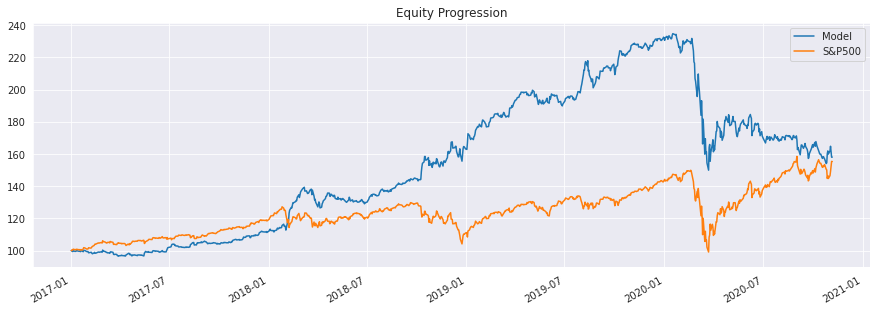

In [ ]:
a_res = a.prices
a.display()
a.plot();

## Puting Whole model in a function and checking if it works

In [ ]:
import final_script_model_M1B_Data_Stream

In [ ]:
final_script_model_M1B_Data_Stream.model_M1B?

* Signature: **final_script_model_M1B.model_M1B(files_path, name1='naya_redefined.csv', name2='rand.csv')**
> * files_path = point dir were above 2 CSVs are kept
> * name1 = points to sp500 index csv

default are names are given above
* Docstring: <no docstring>
* File:      /content/final_script_model_M1B.py
* Type:      function

In [ ]:
files_path = '/content'
model_pred = final_script_model_M1B_Data_Stream.model_M1B(files_path)
print(model_pred)

{'2020-11-09': 0}


## Analysing the previous and new targets
* **To check if there is any difference**

In [ ]:
data[['Target']].to_csv('new_tar.csv',index=True)

In [ ]:
old_tar = pd.read_csv('/content/old_nb_target.csv')
new_tar = pd.read_csv('/content/new_tar.csv')

In [ ]:
old_tar.columns = ["Date",'Target1']
new_tar.columns = ["Date","Target2"]

In [ ]:
comb_tar = old_tar.merge(new_tar,on='Date',how='left')

In [ ]:
print(comb_tar[comb_tar["Target1"]!=comb_tar["Target2"]].shape[0])
comb_tar[comb_tar["Target1"]!=comb_tar["Target2"]]

0


,Date,Target1,Target2


In [ ]:
print(list(data.Target.values == old_tar.Target1.values).count(True))

2511


* **All targets perfectly align with previous notebook**